In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import exposure_function, read_ac_data, gdp_from_cdd_exposure, read_projections, add_historical_gdp_growth, calculate_average_gdp_growth
from utilities.plotting import plot_exposure_map, plot_exposure_contour, plot_gdp_increase_map, plot_gdp_increase_scatter

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

with open('exposure_function_params.pkl', 'rb') as f:
    params = pickle.load(f)

def exposure_new(gdp, cdd):
    return exposure_function(gdp, params['av_a'], params['av_b'], cdd, params['sat_a'], params['sat_b'], params['sat_c'])

outfile_path = 'data_experiencedT/experienced_temperature_data.csv'

In [3]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Experienced temperature data not found, recalculating')
    # Read in historical AC, GDP, DD data
    ac_data_historical = read_ac_data('data_experiencedT/AC_data.csv')
    # Drop AC data column
    ac_data_historical = ac_data_historical.drop(columns='AC')
    # Add historical GDP growth
    ac_data = add_historical_gdp_growth(ac_data_historical, config)

    # Add predictions for DD_mean and GDP for the countries in ac_data
    dd_projections = read_projections(config, 'cdd', ac_data_historical)
    gdp_projections = read_projections(config, 'gdp', ac_data_historical)

    # Merge the two dataframes
    merged_projections = pd.merge(dd_projections, gdp_projections, on='ISO3', how='outer')

    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data, merged_projections, on='ISO3', how='outer')

    # Add column for historical exposure times CDD
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['GDP'], ac_data['DD_mean'])*ac_data['DD_mean']
    ac_data['exposure'] = exposure_new(ac_data['GDP'], ac_data['DD_mean'])

    # Sort by income quantile and label each country with income group
    ac_data['income_group'] = pd.qcut(ac_data['GDP'], 5, labels=config['income_groups_colors'].keys())


In [4]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data.drop(columns=['ISO3'])
ac_data_income_group = ac_data_income_group.groupby('income_group').mean()
# Add row for global average
ac_data_income_group.loc['global average'] = ac_data_income_group.mean()

# Calculate GDP needed to keep exposure times CDD constant
for scenario in config['future_scenarios']:
    # For both countries and income groups
    for df in [ac_data, ac_data_income_group]:
        gdp_const = gdp_from_cdd_exposure(df['exposure_times_cdd'], df['CDD_{0}_{1}'.format(scenario, config['future_years'][-1])], params)
        df['gdp_const_{}'.format(scenario)] = calculate_average_gdp_growth(gdp_const, df['GDP'], config['future_years'][-1] - config['ref_year'])


# Write full dataframe to csv
if not os.path.exists(outfile_path):
    ac_data.to_csv(outfile_path, index=False)

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https:

<Figure size 640x480 with 0 Axes>

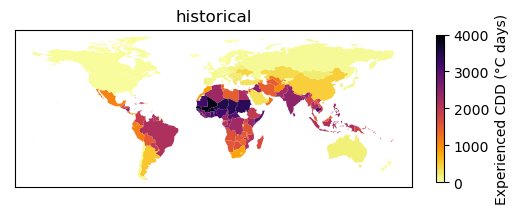

<Figure size 640x480 with 0 Axes>

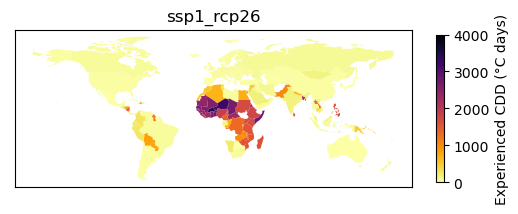

<Figure size 640x480 with 0 Axes>

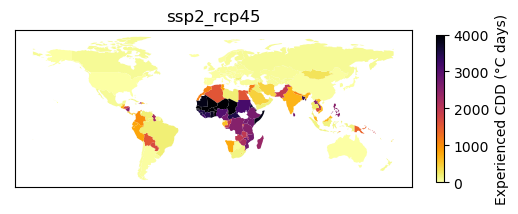

<Figure size 640x480 with 0 Axes>

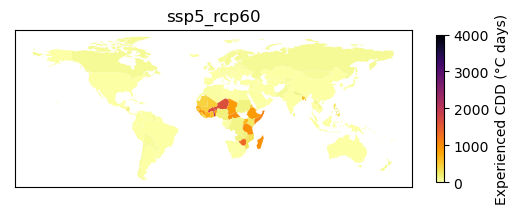

In [5]:
# Plot exposure map
for scenario in ['historical'] + config['future_scenarios']:
    # Figure 1
    plot_exposure_map(config, ac_data, exposure_new, scenario)

    # Figure 4
    # plot_gdp_increase_map(config, ac_data, scenario, exposure_new)

    if scenario == 'historical':
        continue
    
    # Figure 2
    # Plot exposure contour for absoulte CDD and GDP
    # plot_exposure_contour(config, exposure_new, ac_data_income_group, x_y_ranges=[[100, 4000, 100],[1000, 150000, 100]], 
    #                   name_tag='exposure_contour', scenario=scenario)

    # Figure 5
    # plot_gdp_increase_scatter(config, ac_data, scenario)

# Figure 3
# Plot contour for each income group with x and y percent increase in CDD and GDP
# x_max = [4.5, 3., 2., 1.25, 0.25, 1.5]
# for i, income_group in enumerate(config['income_groups_colors'].keys()):
#     if income_group == 'high':
#         neg_cdd = 10
#         neg_gdp = 0.2
#     else:
#         neg_cdd = 0.
#         neg_gdp = 0.
#     plot_exposure_contour(config, exposure_new, ac_data_income_group, x_y_ranges=[[0-neg_cdd, 60, 100],[0-neg_gdp, x_max[i], 100]],
#                     country=income_group, name_tag='exposure_contour_{}'.format(income_group))


    
